In [6]:
dataset_name = "infection"

## 2 layer GAT

In [7]:
# Import the utility functions
import torch
from src.experiment_utils import FaithfulnessExperimentBatch
import networkx as nx
from torch_geometric.utils import get_num_hops

device = torch.device("cpu")
dataset_folder = "/workspace/Datasets"
model_folder = "/workspace/Models"
config = "2L1H"

# Load the network data locally (for reproduction)
data = torch.load(f"{dataset_folder}/Infection_50002d_sp.pt", map_location="cpu").to(device)
# Load model as a whole
model = torch.load(f"{model_folder}/GAT_{dataset_name}_{config}_sp.pt", map_location="cpu").to(device)
model.eval()
k = get_num_hops(model)

with torch.no_grad():
    _  = model(data.x, data.edge_index, return_att = True)
    att = list(model.att)

In [41]:
# Let's turn the process of drawing the local graph with the ground truth path into a function
from torch_geometric.data import Data
from torch_geometric.utils import k_hop_subgraph
import matplotlib.pyplot as plt

# Let's turn the process of drawing the local graph with the ground truth path into a function
def draw_local_comp_graph_with_ground_truth_path(
    data: Data, hops: int, target_idx: int, ground_truth: bool = True
) -> None:
    # First assert that the target index does have a unique ground truth path
    assert (
        target_idx in data.unique_solution_nodes
    ), "Target index does not have a unique ground truth path"
    # Get the local k hop subgraph
    subgraph_nodes, _, _, inv = k_hop_subgraph(
        node_idx=target_idx,
        num_hops=hops,
        edge_index=data.edge_index,
        relabel_nodes=True,
    )
    # Convert nodes and edges to lists
    subgraph_nodes = subgraph_nodes.tolist()
    subgraph_edges = data.edge_index[:, inv].tolist()
    # Transform subgraph_edges to a list of tuples
    subgraph_edges_tup = [
        (subgraph_edges[0][i], subgraph_edges[1][i])
        for i in range(len(subgraph_edges[0]))
    ]
    # Create a directed graph
    G = nx.DiGraph()
    G.add_edges_from(subgraph_edges_tup)
    # Remove self-loops from the graph
    G.remove_edges_from(nx.selfloop_edges(G))
    if ground_truth:
        # Get index of target node in data.unique_solution_nodes
        target_idx_in_unique_solution_nodes = data.unique_solution_nodes.index(
            target_idx
        )
        # Get the ground truth path for target node
        ground_truth_path = data.unique_solution_explanations[
            target_idx_in_unique_solution_nodes
        ]
        # Convert the ground truth path to a list of tuples
        ground_truth_path_tup = [
            (ground_truth_path[i], ground_truth_path[i + 1])
            for i in range(len(ground_truth_path) - 1)
        ]
    # Draw the graph with subgraph_nodes as node labels
    # Highlight the path from ground_truth_path_tup with red edges
    # Also highlight the target node with a different color
    plt.figure(figsize=(8, 8), dpi=120)
    pos = nx.spring_layout(G, seed=0)
    node_size = 600
    nx.draw(
        G,
        pos=pos,
        node_color="#D8D4F2",
        node_size=node_size,
        # font_size=16,
        width=2,
        edgecolors="black",
        linewidths=2,
        edge_color="black",
        arrowstyle="-|>",
        # labels={node: node for node in subgraph_nodes},
        # with_labels=True,
        font_weight="normal",
    )
    if ground_truth:
        nx.draw_networkx_edges(
            G,
            pos=pos,
            edgelist=ground_truth_path_tup,
            edge_color="#dc143c",
            width=2,
            arrows=True,
            arrowsize=20,
            node_size=node_size,
        )
    nx.draw_networkx_nodes(
        G, 
        pos=pos, 
        nodelist=[target_idx], 
        node_color="#FF8C00", 
        node_size=node_size,
        linewidths=2,
        edgecolors="black",
    )
    plt.show()

def draw_local_comp_graph_with_attribution_scores(
    data: Data, hops: int, target_idx: int, att_matrix: torch.Tensor
) -> None:
    # First assert that the target index does have a unique ground truth path
    assert (
        target_idx in data.unique_solution_nodes
    ), "Target index does not have a unique ground truth path"
    # Get the local k hop subgraph
    subgraph_nodes, _, _, inv = k_hop_subgraph(
        node_idx=target_idx,
        num_hops=hops,
        edge_index=data.edge_index,
        relabel_nodes=True,
    )
    # Convert nodes and edges to lists
    subgraph_nodes = subgraph_nodes.tolist()
    subgraph_edges = data.edge_index[:, inv].tolist()
    # Transform subgraph_edges to a list of tuples
    subgraph_edges_tup = [
        (subgraph_edges[0][i], subgraph_edges[1][i])
        for i in range(len(subgraph_edges[0]))
    ]
    # Create a directed graph
    G = nx.DiGraph()
    G.add_edges_from(subgraph_edges_tup)

    # Draw the graph with subgraph_nodes as node labels
    # Also highlight the target node with a different color
    plt.figure(figsize=(8, 8), dpi=120)
    pos = nx.spring_layout(G, seed=0)
    node_size = 500
    nx.draw(
        G,
        pos=pos,
        node_color="#D8D4F2",
        node_size=node_size,
        # font_size=16,
        width=1,
        edgecolors="black",
        linewidths=2,
        edge_color="white",
        arrowstyle="-|>",
        # labels={node: node for node in subgraph_nodes},
        # with_labels=True,
        font_weight="normal",
    )

    # Get the edge attribution scores from att_matrix
    # Edge (i,j) is weighted by att_matrix[j,i]
    # Normalize att_matrix to [0,0.8] for better visualization
    att_matrix = att_matrix / att_matrix.max() * 0.8
    
    edge_color = [att_matrix[edge[1], edge[0]].item() for edge in subgraph_edges_tup]
    nx.draw_networkx_edges(
        G,
        pos=pos,
        edgelist=subgraph_edges_tup,
        edge_color=edge_color,
        edge_vmin=0,
        edge_vmax=1,
        width=2,
        edge_cmap=plt.cm.OrRd,
        min_target_margin=12,
        min_source_margin=12,
    )
    nx.draw_networkx_nodes(
        G, 
        pos=pos, 
        nodelist=[target_idx], 
        node_color="#FF8C00", 
        node_size=node_size,
        edgecolors="black",
        linewidths=2,
        label = {node: node for node in subgraph_nodes},
    )
    plt.show()

Case study: Node 355

In [26]:
data.unique_solution_nodes[77]

355

Target nodes set...
Generating edge lists within 2 hops of target nodes...
...Done
Getting attributions for 1 nodes...
...Done


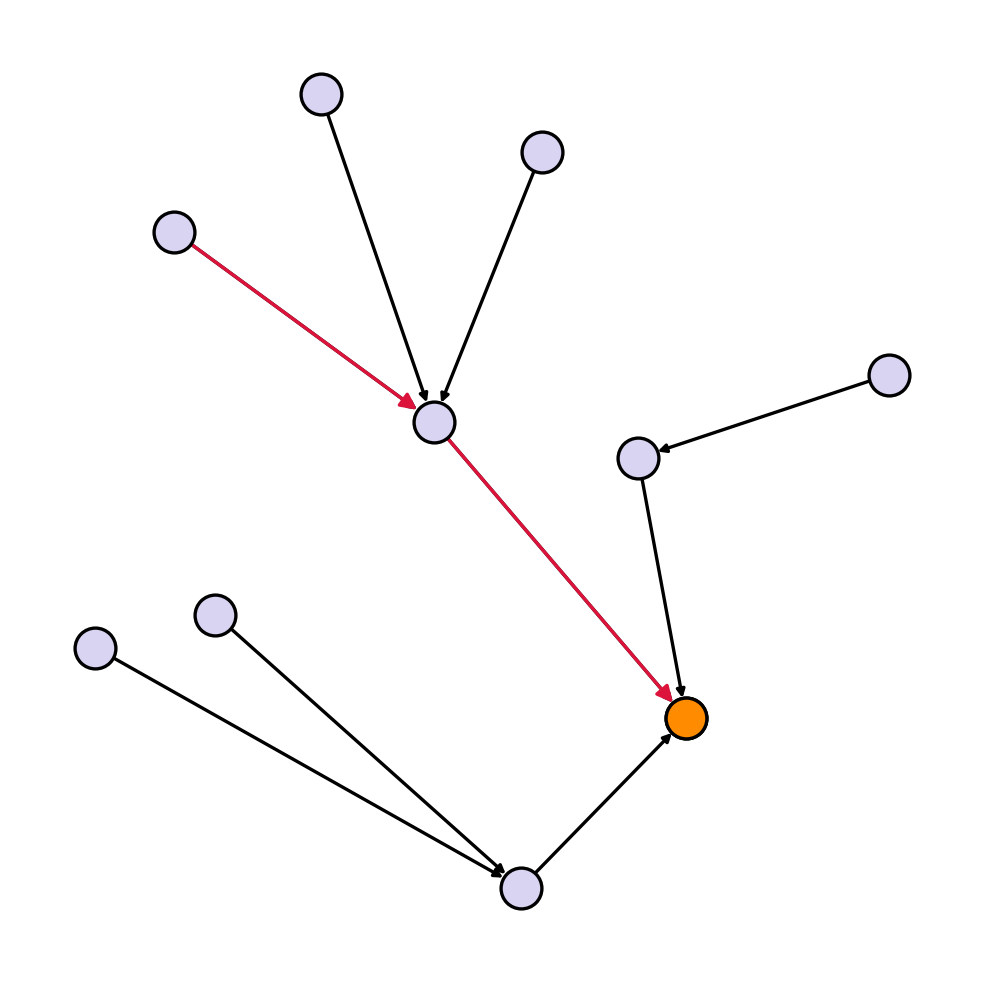

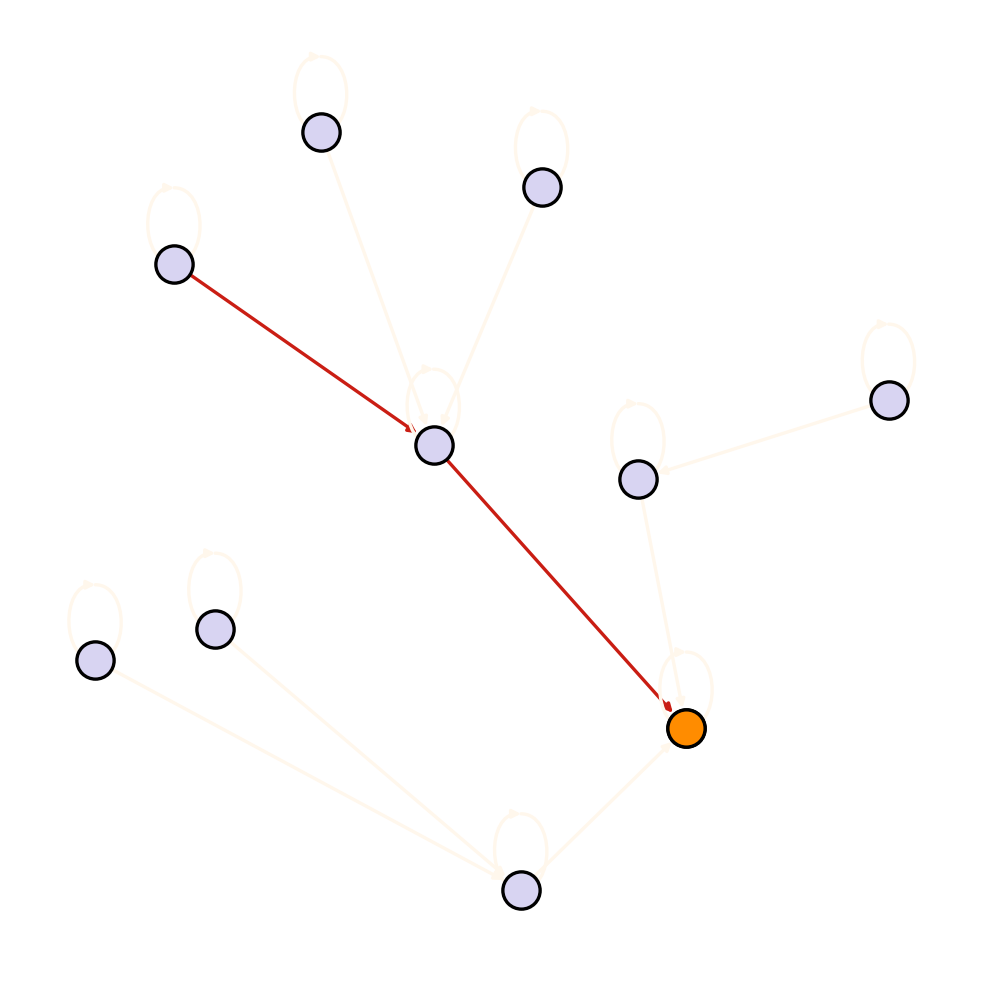

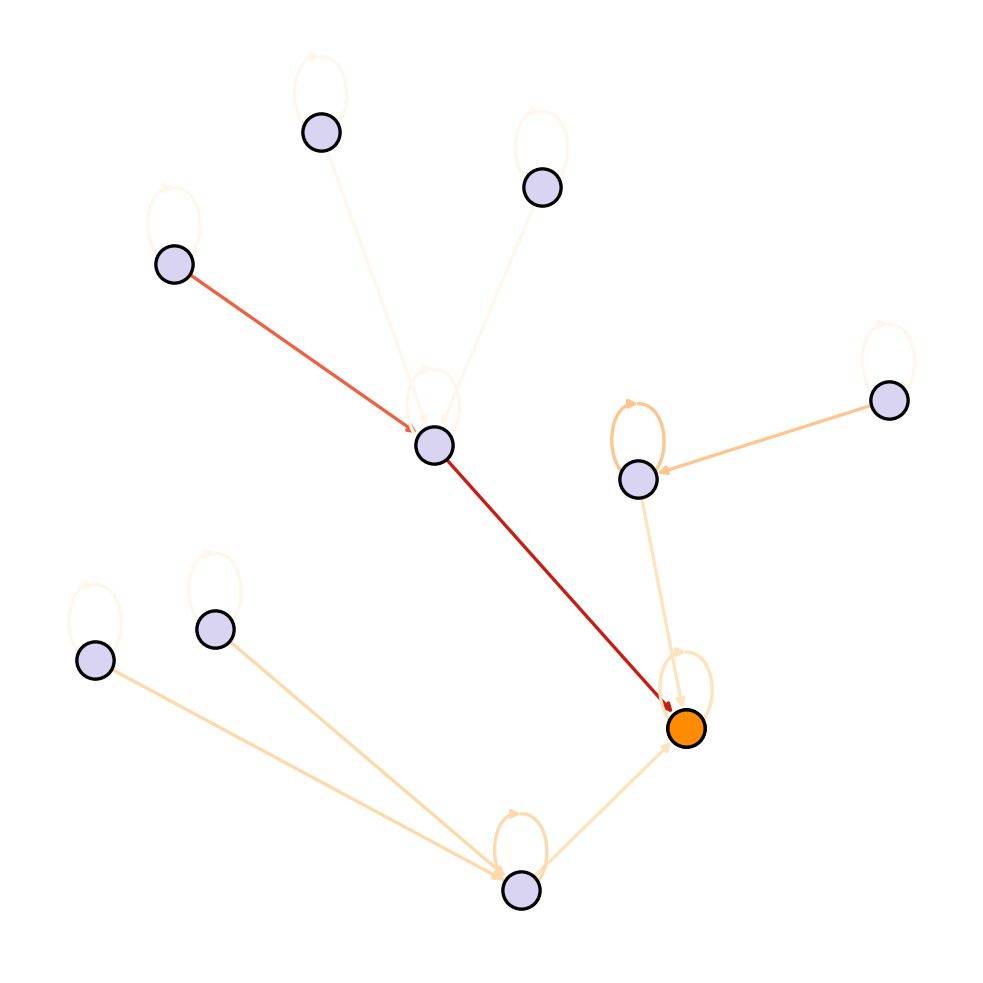

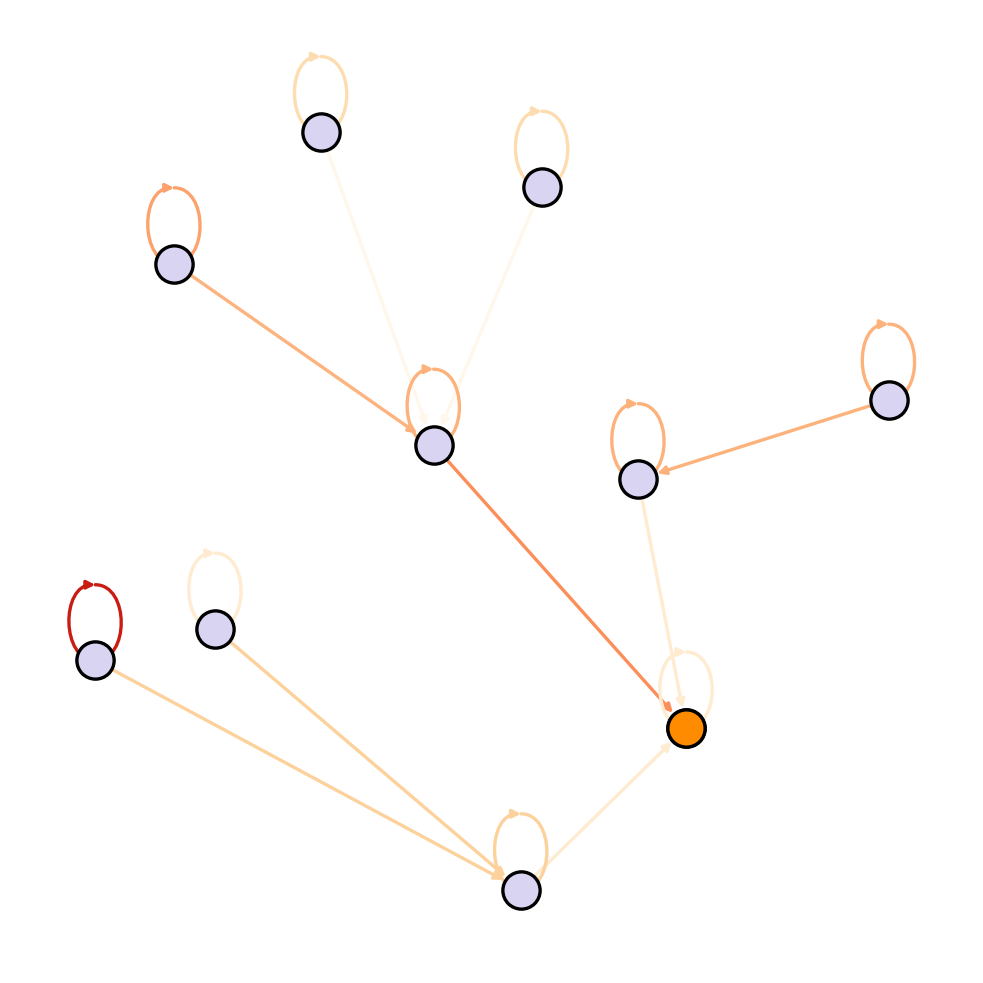

In [9]:
target_node = data.unique_solution_nodes[77]
experiment = FaithfulnessExperimentBatch(model = model, data = data, device = "cpu")
experiment.set_target_nodes([target_node])
_ = experiment.get_attributions()
att_matrix_dict, _ = experiment._prep_to_get_attattribute()
attattribute = experiment.attattribute_matrix
attattribute_sim = experiment.attattribute_sim_matrix
avg_att = torch.stack([att_matrix_dict[key] for key in att_matrix_dict.keys()]).mean(dim = 0).squeeze()

draw_local_comp_graph_with_ground_truth_path(
    data = data,
    hops = k,
    target_idx = target_node,
    ground_truth = True,
)

draw_local_comp_graph_with_attribution_scores(
    data = data,
    hops = k,
    target_idx = target_node,
    att_matrix = attattribute,
)

draw_local_comp_graph_with_attribution_scores(
    data = data,
    hops = k,
    target_idx = target_node,
    att_matrix = attattribute_sim,
)

draw_local_comp_graph_with_attribution_scores(
    data = data,
    hops = k,
    target_idx = target_node,
    att_matrix = avg_att,
)

In [16]:
raw_att_0 = torch.zeros_like(experiment.attattribute_matrix)
raw_att_0[model.att[0][0][1], model.att[0][0][0]] = model.att[0][1].squeeze()

raw_att_1 = torch.zeros_like(experiment.attattribute_matrix)
raw_att_1[model.att[1][0][1], model.att[1][0][0]] = model.att[1][1].squeeze()

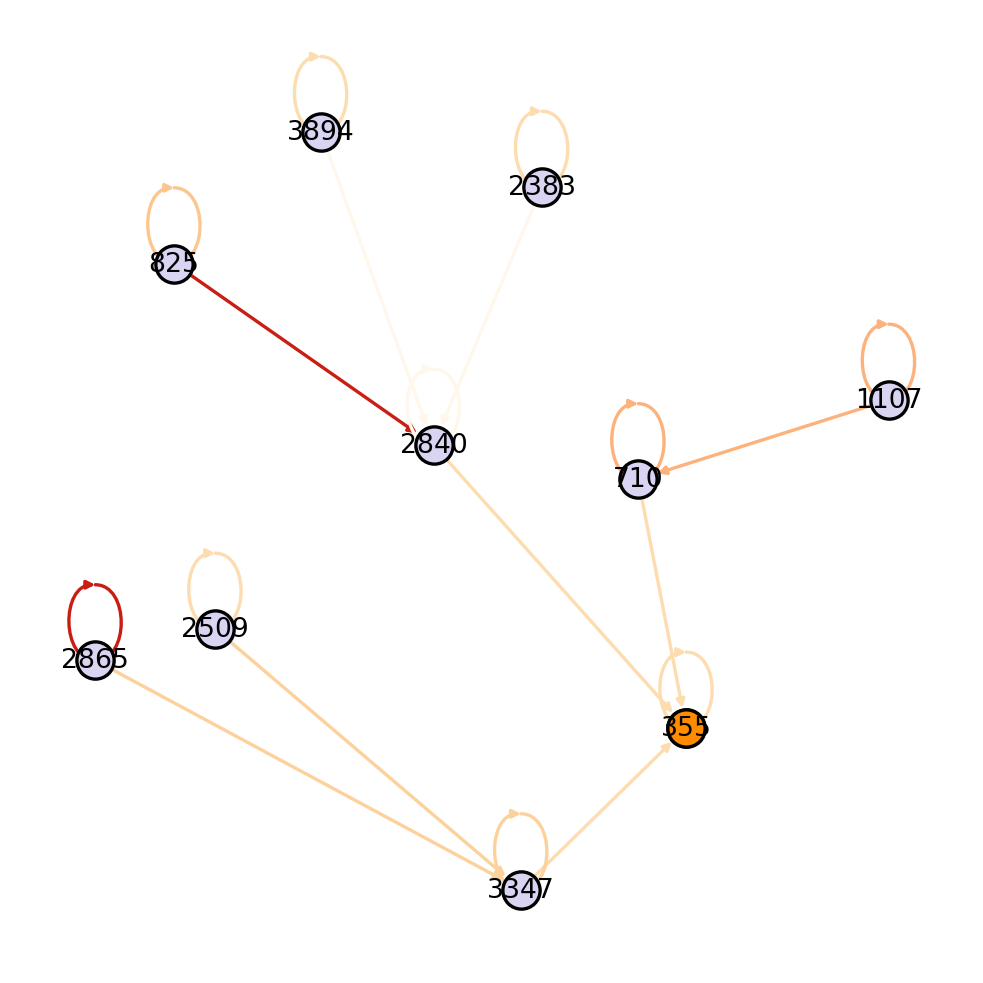

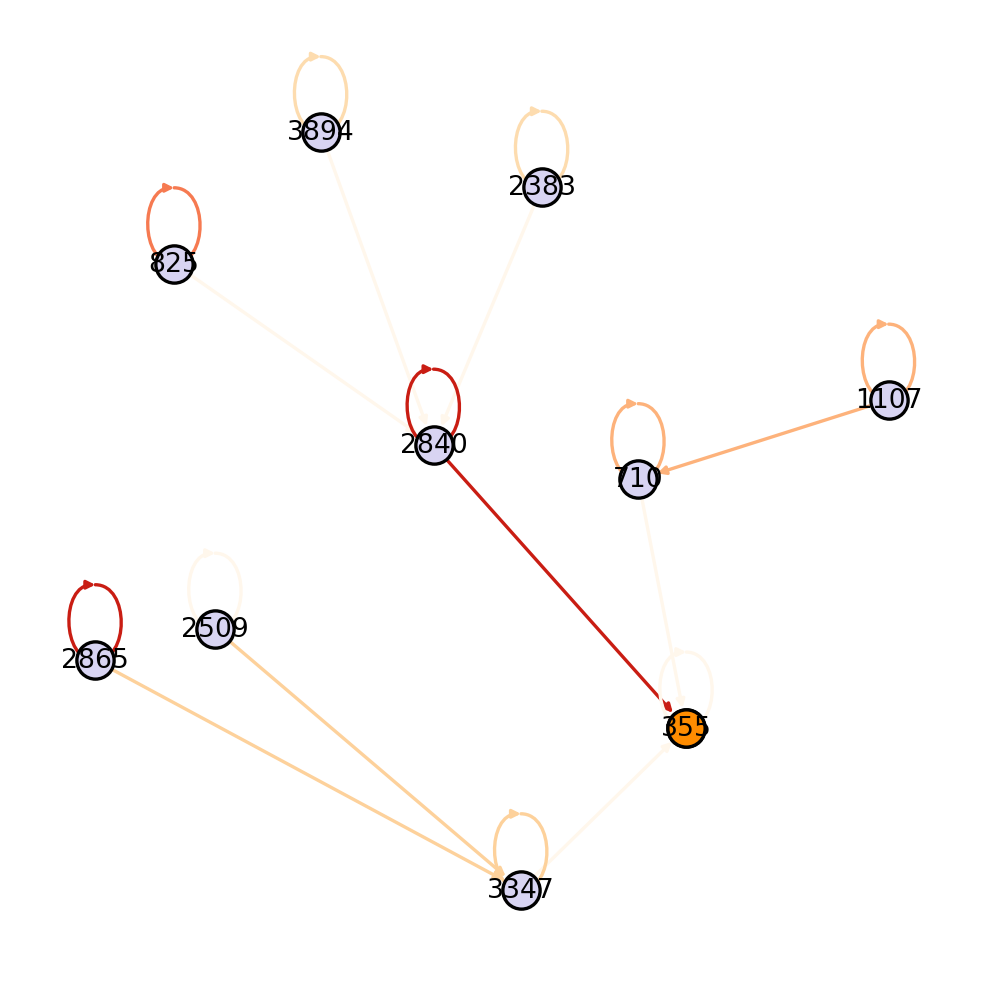

In [40]:
draw_local_comp_graph_with_attribution_scores(
    data = data,
    hops = k,
    target_idx = target_node,
    att_matrix = raw_att_0,
)

draw_local_comp_graph_with_attribution_scores(
    data = data,
    hops = k,
    target_idx = target_node,
    att_matrix = raw_att_1,
)

In [18]:
subgraph_nodes, _, _, inv = k_hop_subgraph(
    node_idx=target_node,
    num_hops=2,
    edge_index=data.edge_index,
    relabel_nodes=True,
)
subgraph_nodes

tensor([ 355,  710,  825, 1107, 2383, 2509, 2840, 2865, 3347, 3894])

In [22]:
mini_att_0 = raw_att_0[subgraph_nodes, :][:, subgraph_nodes]
mini_att_1 = raw_att_1[subgraph_nodes, :][:, subgraph_nodes]

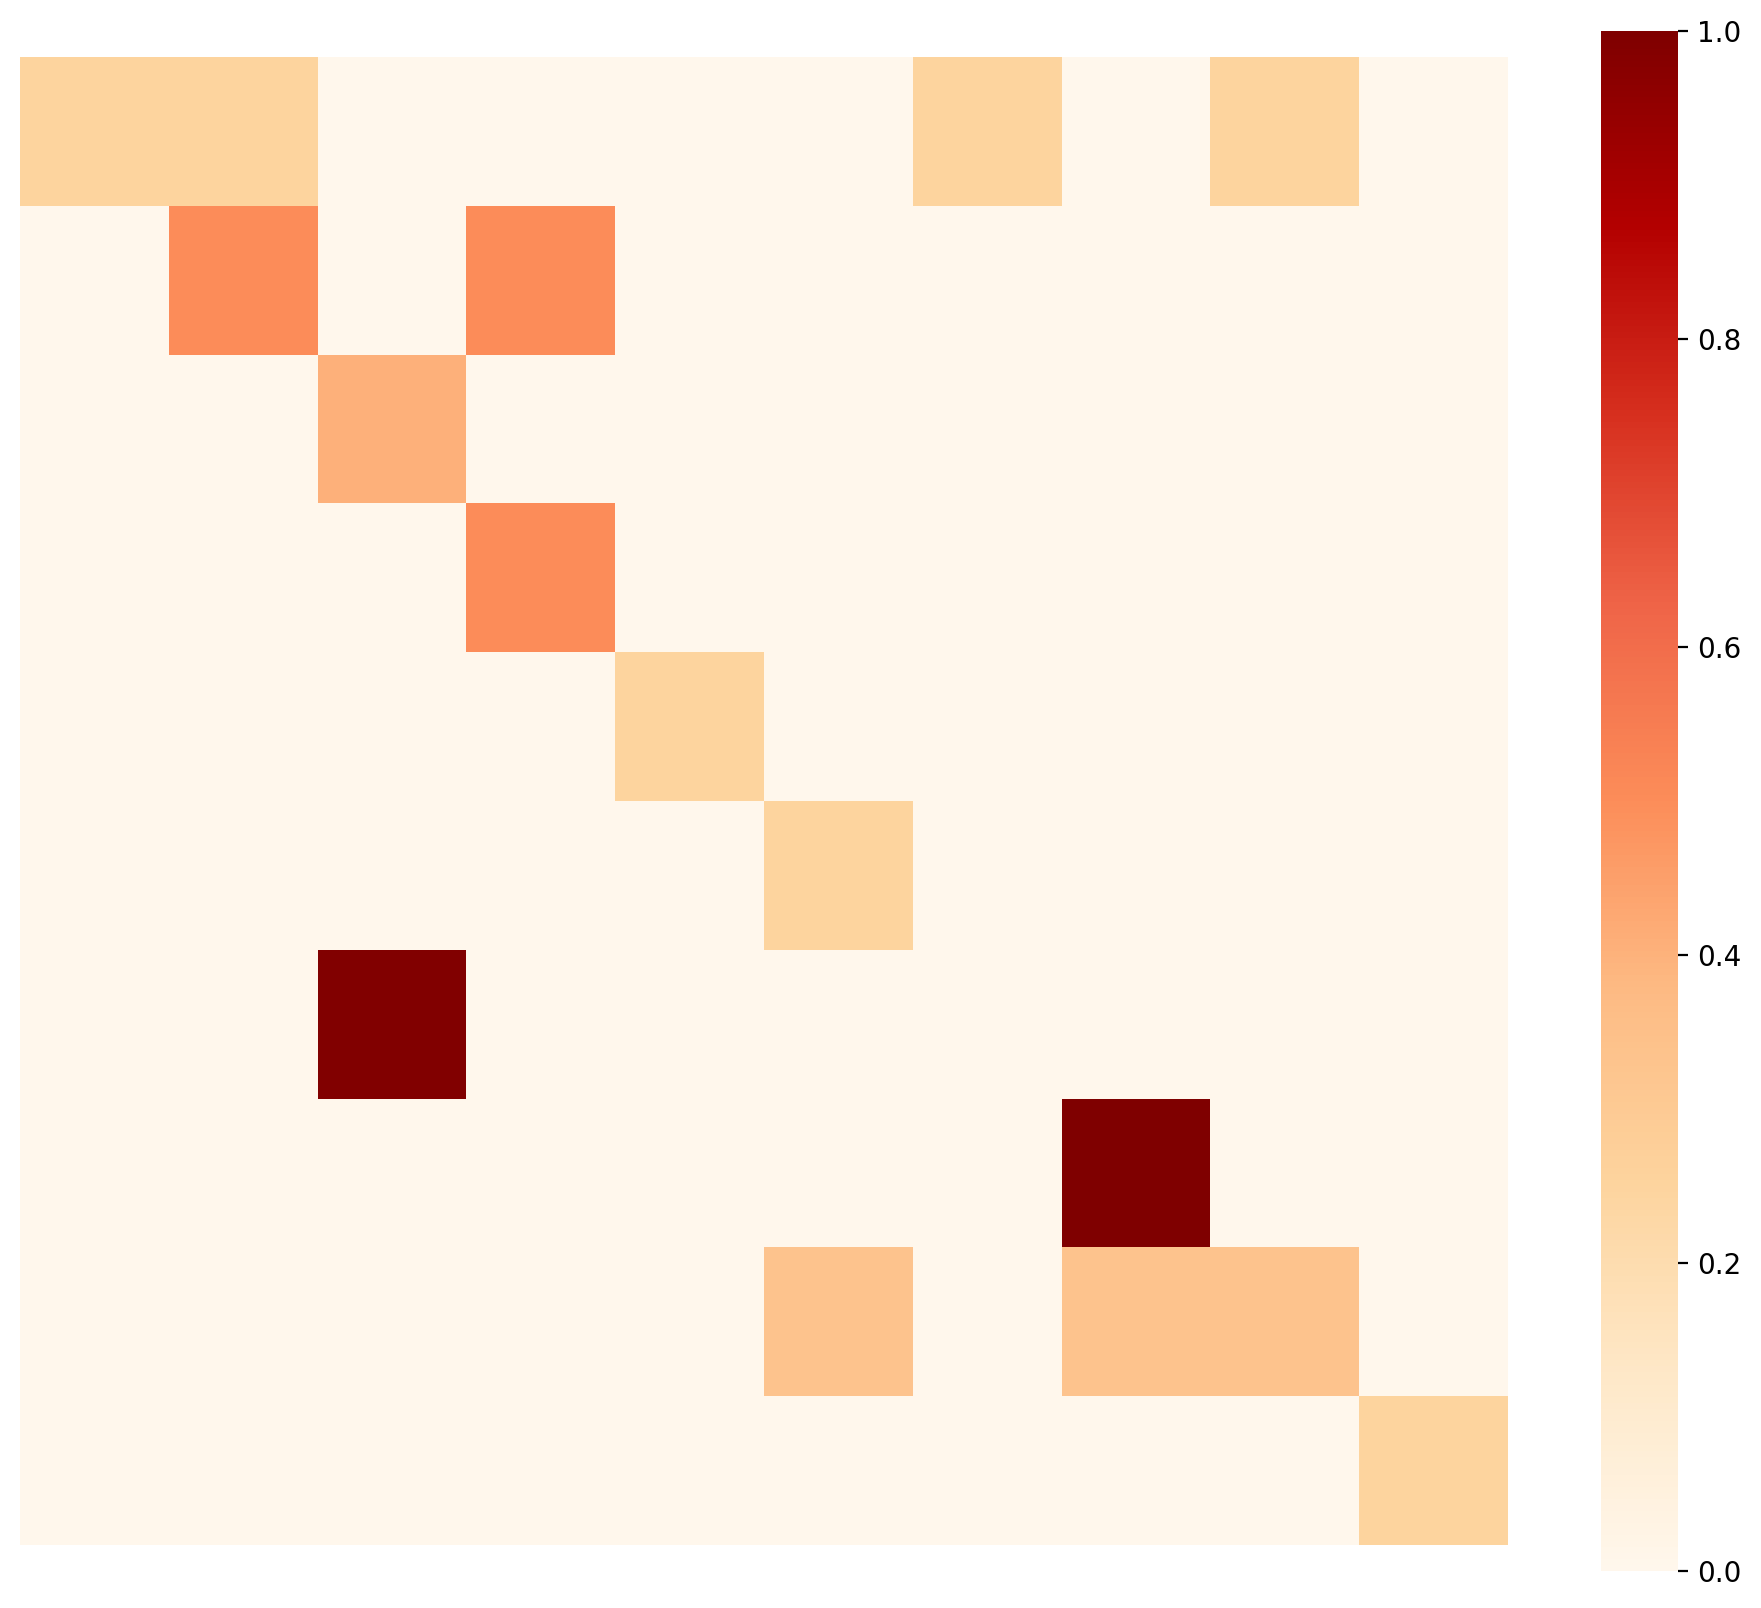

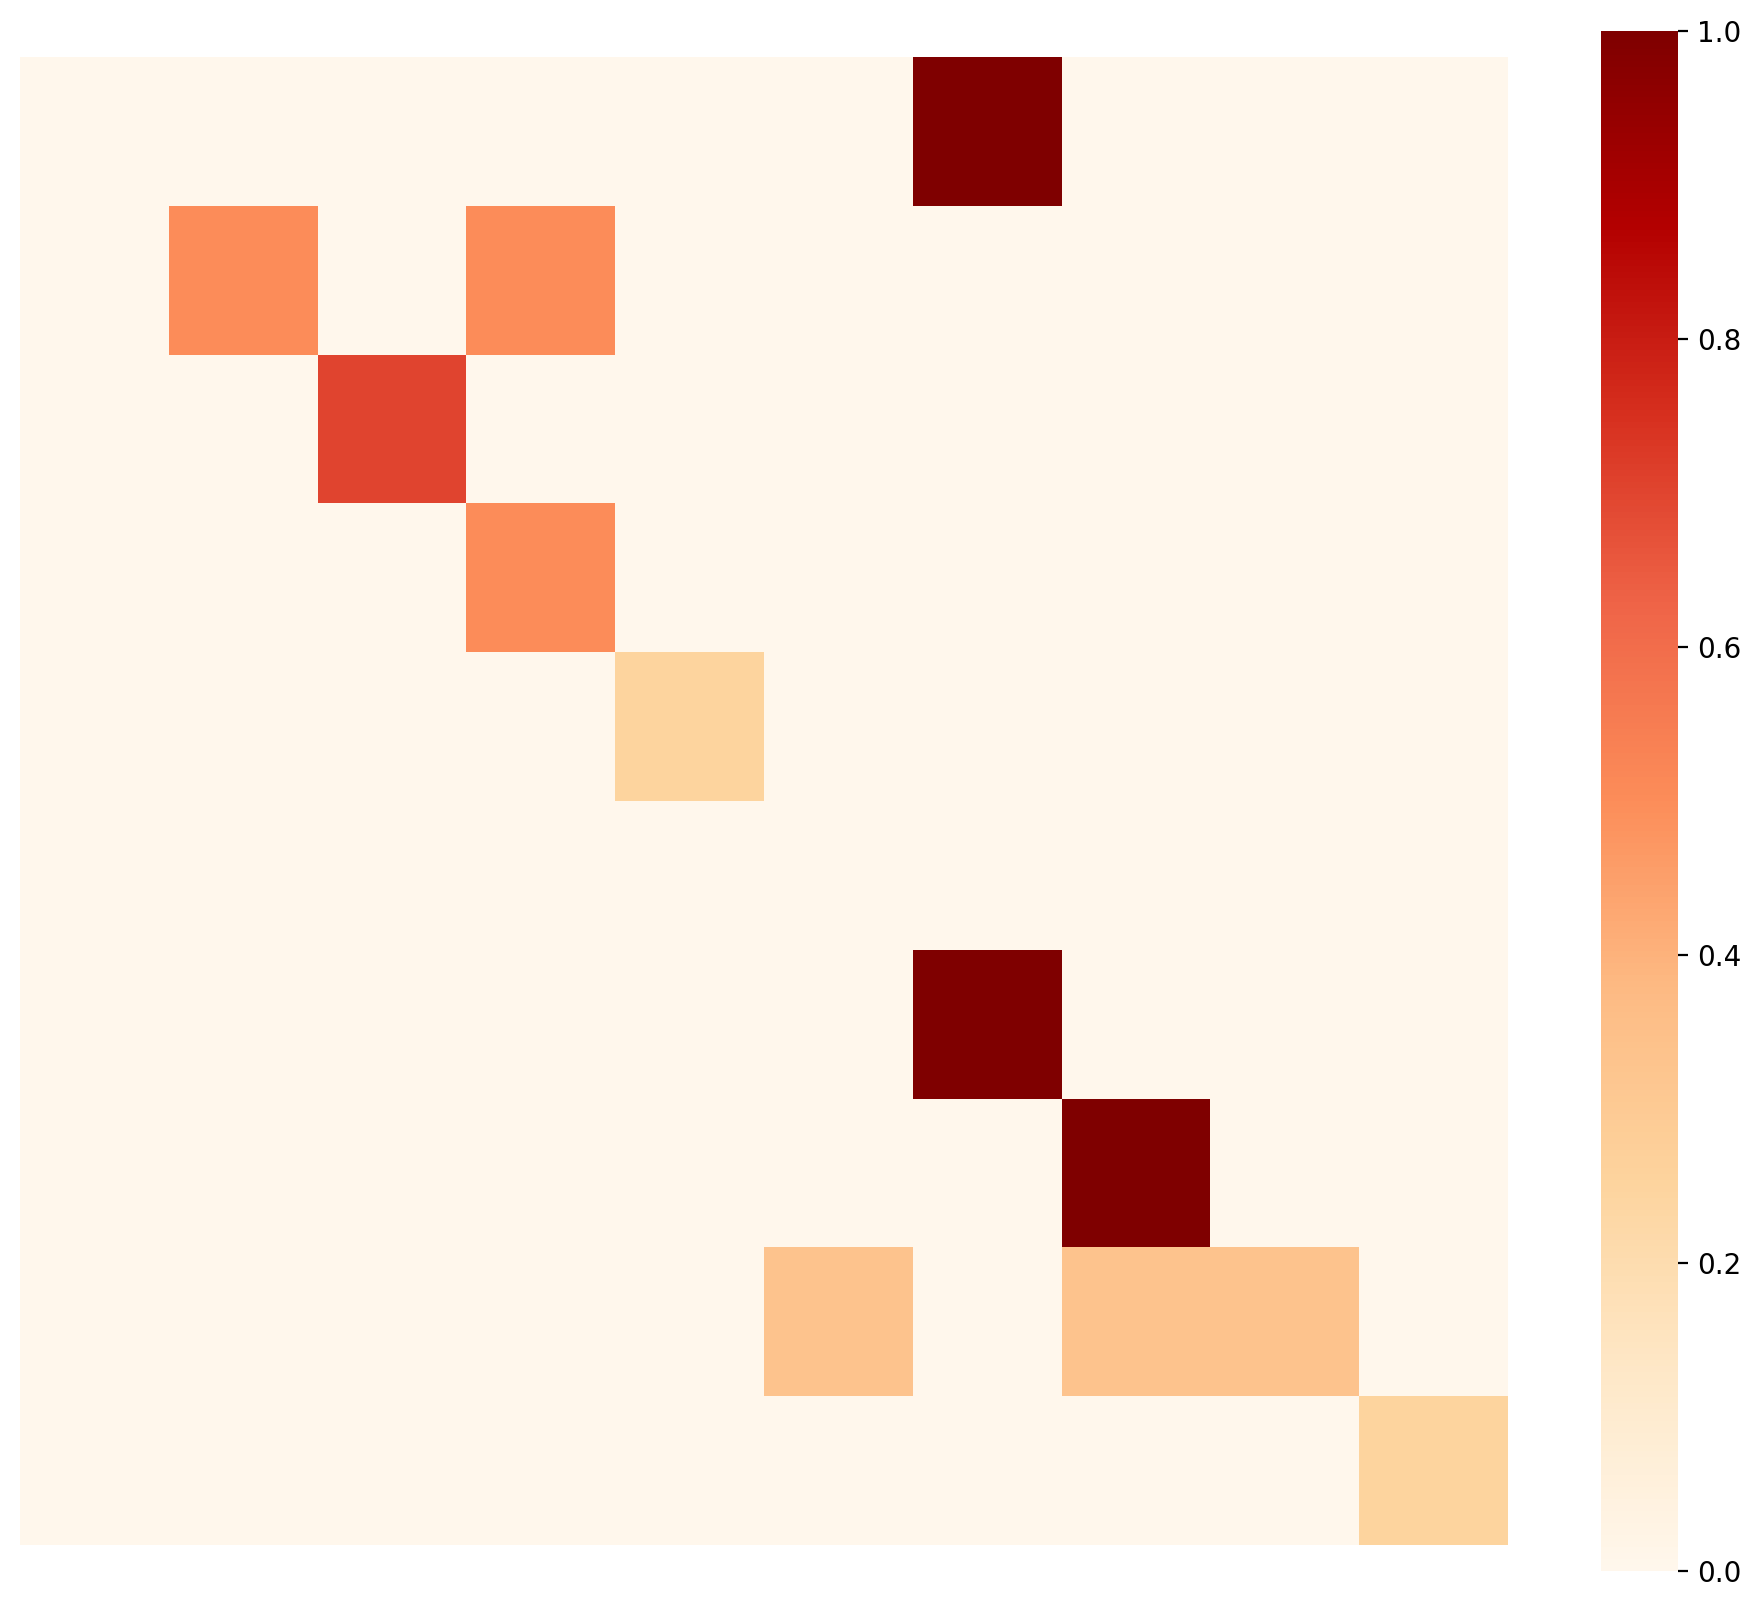

In [24]:
# Draw raw attention weights
import matplotlib.pyplot as plt
import seaborn as sns

# Plot raw_att0 only
plt.figure(figsize = (12, 10), dpi = 200)
sns.heatmap(mini_att_0,
            cmap = "OrRd", 
            square = True, 
            cbar = True,
            xticklabels=False,
            yticklabels=False)
plt.show()

# Plot raw_att0 only
plt.figure(figsize = (12, 10), dpi = 200)
sns.heatmap(mini_att_1,
            cmap = "OrRd", 
            square = True, 
            cbar = True,
            xticklabels=False,
            yticklabels=False)
plt.show()

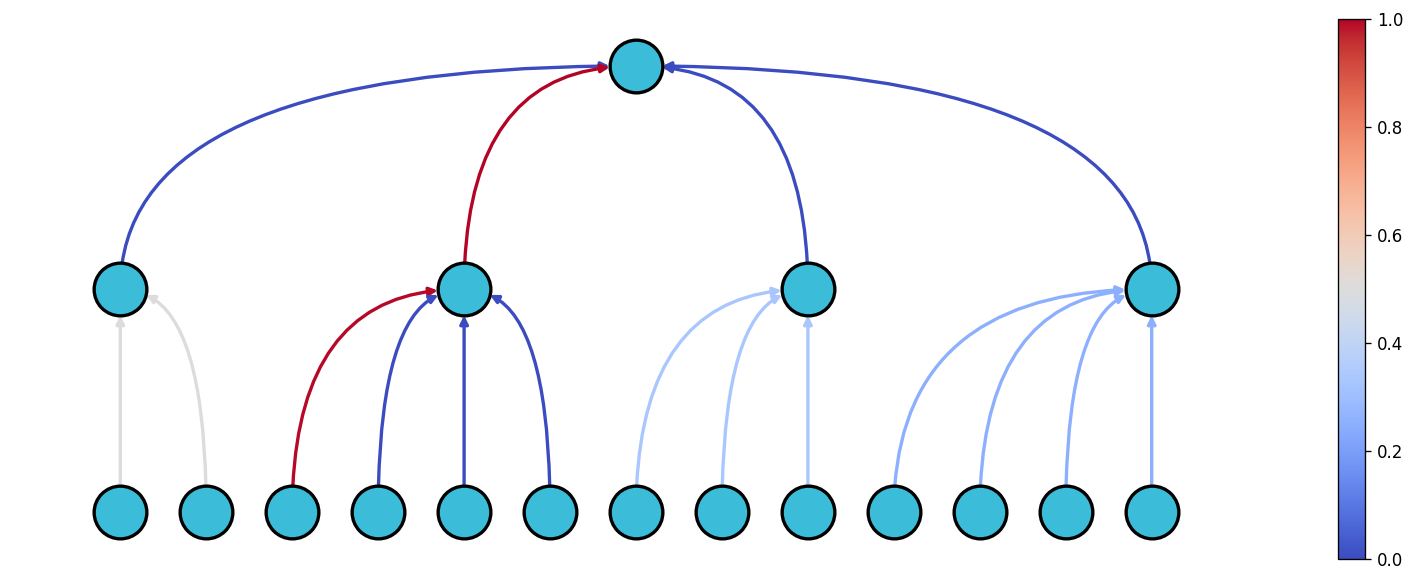

In [43]:
# Import the utility functions
from src.attention_analysis_utils import (
    get_attention_raw_dict,
    process_attention_dict,
    get_computation_graph,
    get_nodes_per_level_from_comp_graph_full,
    get_attention_raw_dict_multihead,
    reindex_nodes_per_level,
    translate_comp_graph,
    get_att_dict_per_layer,
)

from src.visualization_utils import (
    visualize_computation_graph,
)
from torch_geometric.utils import degree


# num_layers = get_num_hops(model)
num_layers = 2

att_dict_raw = get_attention_raw_dict_multihead(model, data)
att_dict = process_attention_dict(att_dict_raw)
comp_graph = get_computation_graph(
    edge_index=data.edge_index, k=num_layers, target_idx=target_node
)
(
    nodes_per_level_original,
    num_nodes_per_level,
    true_node_label,
) = get_nodes_per_level_from_comp_graph_full(comp_graph=comp_graph)
nodes_per_level_new = reindex_nodes_per_level(
    nodes_per_level_original, num_nodes_per_level
)
comp_graph_new = translate_comp_graph(
    comp_graph=comp_graph,
    nodes_per_level_new=nodes_per_level_new,
    nodes_per_level_original=nodes_per_level_original,
    degree = degree(data.edge_index[1])
)
reverse_att_dict = {}
reverse_att_dict[0] = att_dict[1]
reverse_att_dict[1] = att_dict[0]
layer_att_dict = get_att_dict_per_layer(
    comp_graph=comp_graph, comp_graph_new=comp_graph_new, att_dict=reverse_att_dict
)
visualize_computation_graph(
    layer_att_dict=layer_att_dict,
    nodes_per_level_new=nodes_per_level_new,
    true_node_label=true_node_label,
    with_labels=False
)